<a href="https://colab.research.google.com/github/MNazamy/data_analytics/blob/main/Python/DiabeticHospitalReadmission_MiniProject_Unit4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
From GitHub. 

This data is from over 130 hospitals who pooled together patient data in the hopes that data scientists can help find breakthroughs in medical treatment, and prediction of future patient health issues. 

In this project, we intend to build a predictive model that can accurately answer the question "Can we accurately predict if a patient will be readmitted to the hospital, and if so, can we predict whether the readmittion will happen in 30 days?"



# Imports and Data Reading


In [1477]:
#Standard Libraries for visualization and data wrangling 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
sns.set_style('whitegrid')

#Logistic Regression Models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

%matplotlib inline

In [1478]:
# Reading CSV
missing_values = ['?'] #only null values came in the form of '?'
df = pd.read_csv('https://raw.githubusercontent.com/buildwelllabs/machine.learning.project/master/diabetic_data.csv',na_values = missing_values)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1479]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# EDA

In [1480]:
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'lightgrey'},) #background color

### HeatMap of our null data
-- Gives us some pointers on how to start tackling our data. 

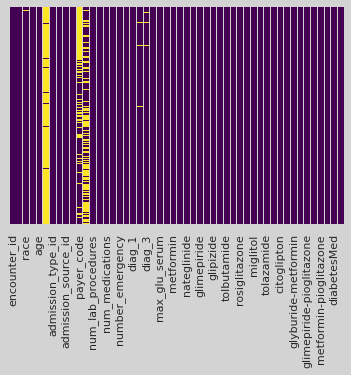

In [1481]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Counting Readmissions
--Comparing the patients who were readmitted. About 53%, of patients don't need to be readmitted, about 35% return after 30 days.

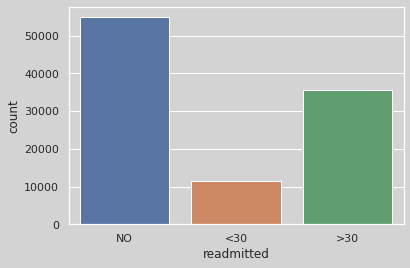

In [1482]:
sns.countplot(data=df,x=df['readmitted'],order=['NO','<30','>30'])

### Number of Diagnoses vs.Time spent in the hospital. 
-- Seems to indicate that those who have more diagnoses tend to have longer stays in the hospital. The means of each category corrolated with more time in the hospital. For some reason there is a dip between 10-12 diagnoses.

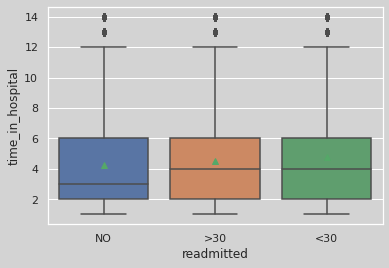

In [1483]:
sns.boxplot(x='readmitted', y='time_in_hospital', data=df,showmeans=True)

### Age 
-- It seems those in older age groups are more likely to have longer stays in the hospital.

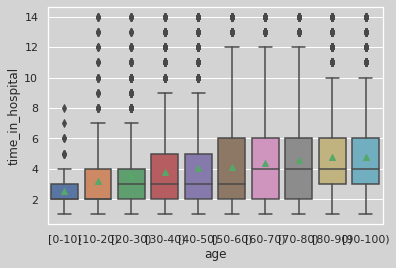

In [1484]:
sns.boxplot(x='age', y='time_in_hospital', data=df,showmeans=True)


### Gender
-- Have to conclude that time spent in hospital and number of diagnoses is independent of gender. So it's probably that readmissions will also be independent.

In [1485]:
df['gender'].replace({'Unknown/Invalid': 'Female'}, regex=True,inplace=True) #only doing this to fix 3 values in 100,000. Dataset is about 55% female so I chose female.

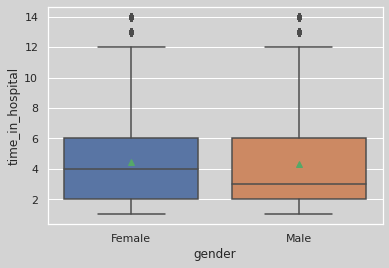

In [1486]:
sns.boxplot(x='gender', y='time_in_hospital', data=df,showmeans=True) #dont see a big correlation for gender.

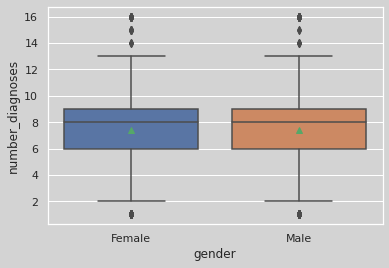

In [1487]:
sns.boxplot(x='gender',y='number_diagnoses',data=df,showmeans=True)

### Race
-- like gender, race also seems to not be a big factor. looks evenly distributed along this.

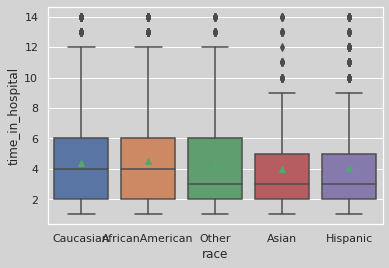

In [1488]:
sns.boxplot(x='race', y='time_in_hospital', data=df,showmeans=True)


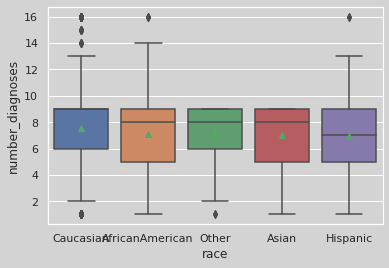

In [1489]:
sns.boxplot(x='race', y='number_diagnoses', data=df,showmeans=True)


# Data Cleaning

## First DF

### Dropping some columns we know we won't use

In [1491]:
df.drop(['encounter_id','patient_nbr','weight','payer_code','medical_specialty','diag_1','diag_2','diag_3',],axis=1,inplace=True) 

In [1492]:
df.drop(['admission_type_id','discharge_disposition_id','admission_source_id','max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide'],axis=1,inplace=True)

In [1493]:
#these drugs all had very few values , about 100 or less. in a dataset of 100k that is miniscule and could sway data
df.drop(['chlorpropamide','acetohexamide', 'tolbutamide','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'],axis=1,inplace=True)

In [1494]:
#df2 is used for an attempt with different numbers
df2 = df.copy()

In [1495]:
df.drop(['change','number_outpatient', 	'number_emergency', 'number_inpatient'],axis=1,inplace=True)

In [1496]:
#these drugs had about 5000 or more non-NOs so
df.drop(['glimepiride', 	'glipizide', 	'glyburide', 	'pioglitazone', 	'rosiglitazone'],axis=1,inplace=True)

### Fixing the null values in race column

In [1497]:
df['race'].fillna('Other',inplace=True) #fixing NA values in race

In [1498]:
df.replace({'Caucasian': '1'}, regex=True,inplace=True) #resaving the races as numeric values for comparisons
df.replace({'AfricanAmerican': '2'}, regex=True,inplace=True)
df.replace({'Asian': '3'}, regex=True,inplace=True)
df.replace({'Hispanic': '4'}, regex=True,inplace=True)
df.replace({'Other': '5'}, regex=True,inplace=True)


### Setting the age column to numeric values

In [1499]:
df.replace({'\[0-10\)': '0'}, regex=True,inplace=True) #resaving the age as numeric values for comparisons
df.replace({'\[10-20\)': '1'}, regex=True,inplace=True)
df.replace({'\[20-30\)': '2'}, regex=True,inplace=True)
df.replace({'\[30-40\)': '3'}, regex=True,inplace=True)
df.replace({'\[40-50\)': '4'}, regex=True,inplace=True)
df.replace({'\[50-60\)': '5'}, regex=True,inplace=True)
df.replace({'\[60-70\)': '6'}, regex=True,inplace=True)
df.replace({'\[70-80\)': '7'}, regex=True,inplace=True)
df.replace({'\[80-90\)': '8'}, regex=True,inplace=True)
df.replace({'\[90-100\)': '9'}, regex=True,inplace=True)

### Fixing the gender column to dummy numeric values

In [1500]:
sex = pd.get_dummies(df['gender'], drop_first=True)
df = pd.concat([df,sex ],axis=1)

In [1501]:
df.drop('gender',axis=1,inplace=True)

### Fixing diabetes Medication column to dummy numeric values

In [1502]:
diabmed = pd.get_dummies(df['diabetesMed'], drop_first=True)
df = pd.concat([df,diabmed ],axis=1)
df.drop('diabetesMed',axis=1,inplace=True)
df.rename(columns={'Yes':'Diabetes Med'},inplace=True)

### Fixing readmission column to numeric values

In [1503]:
df.replace({'NO': '0'}, regex=True,inplace=True) #resaving the age as numeric values for comparisons
df.replace({'<30': '1'}, regex=True,inplace=True)
df.replace({'>30': '2'}, regex=True,inplace=True)



### trying out change column

### fixing insulin for DF

In [1504]:
df['insulin'].replace({'No': '0'}, regex=True,inplace=True) #if their insulin isnt a problem today, it might not be a problem within 30 days
df['insulin'].replace({'Steady': '0'}, regex=True,inplace=True)
df['insulin'].replace({'Down': '1'}, regex=True,inplace=True)
df['insulin'].replace({'Up': '1'}, regex=True,inplace=True)

### set all values to numeric

In [1505]:
for column in df:
  pd.to_numeric(df[column])
  print (df[column].dtype)

object
object
int64
int64
int64
int64
int64
object
object
uint8
uint8


## Second DF

### editing some cols based on first df

In [1506]:
#df2 independent variables:
# 1. time_in_hospital
# 2. num_lab_procedures
# 3. num_procedures
# 4. num_medications
# 5. number_diagnoses
# 6. diabetes med
# 7. 

#dependent variable:
#readmitted
df2['readmitted'] = df['readmitted']
df2['age'] = df['age']

##more stuff dropping last minute

df2.drop(['num_lab_procedures','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone'],axis=1,inplace=True)
df2.drop('race',axis=1,inplace=True)
df2.drop('gender',axis=1,inplace=True)
df2.drop(['diabetesMed'],axis=1,inplace=True)
#df2['race'] = df['race']


### patient drugs


In [1507]:
df2.replace({'No': '0'}, regex=True,inplace=True) #if their insulin isnt a problem today, it might not be a problem within 30 days
df2.replace({'Steady': '1'}, regex=True,inplace=True)
df2.replace({'Down': '1'}, regex=True,inplace=True)
df2.replace({'Up': '1'}, regex=True,inplace=True)

#only if you want to test a few things
#df2.drop(['glimepiride', 	'glipizide', 	'glyburide', 	'pioglitazone', 	'rosiglitazone'],axis=1,inplace=True)

### fixing the change column

In [1508]:
df2['change'].replace({'No':'0'},regex=True,inplace=True)
df2['change'].replace({'Ch':'1'},regex=True,inplace=True)


In [1509]:
#df2.replace({'Yes':'1','No':'2'},regex=True,inplace=True)

###  setting values to numeric in df2

In [1510]:
for column in df2: #making sure everything is numeric digits that can be computed
  pd.to_numeric(df2[column])

### fixing admission values for df2 (3 values

In [1511]:
df2.replace({'NO': '0'}, regex=True,inplace=True) #resaving the age as numeric values for comparisons
df2.replace({'<30': '1'}, regex=True,inplace=True)
df2.replace({'>30': '2'}, regex=True,inplace=True)

# Model Building and Evaluation

In [1512]:
ds = df
ds2 = df2


In [1513]:
df.head()

,race,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,insulin,readmitted,Male,Diabetes Med
0,1,0,1,41,0,1,1,0,0,0,0
1,1,1,3,59,0,18,9,1,2,0,1
2,2,2,2,11,5,13,6,0,0,0,1
3,1,3,2,44,1,16,7,1,0,1,1
4,1,4,1,51,0,8,5,0,0,1,1


In [1514]:
df2.head()

,age,time_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,insulin,change,readmitted
0,0,1,0,1,0,0,0,1,0,0,0
1,1,3,0,18,0,0,0,9,1,1,2
2,2,2,5,13,2,0,1,6,0,0,0
3,3,2,1,16,0,0,0,7,1,1,0
4,4,1,0,8,0,0,0,5,1,1,0


## Test with df

In [1515]:
x = ds.drop('readmitted',axis=1)
y = ds['readmitted']
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=101) 

In [1516]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### log model

In [1517]:
logmodel = LogisticRegression(class_weight='balanced')
logmodel.fit(X_train, y_train)
logpredict = logmodel.predict(X_test)

In [1518]:

print(classification_report(y_test,logpredict))
print(confusion_matrix(y_test, logpredict))

              precision    recall  f1-score   support

           0       0.61      0.49      0.54     13741
           1       0.14      0.36      0.20      2838
           2       0.39      0.30      0.34      8863

    accuracy                           0.41     25442
   macro avg       0.38      0.38      0.36     25442
weighted avg       0.48      0.41      0.43     25442

[[6675 3693 3373]
 [1020 1034  784]
 [3315 2911 2637]]


### knn

In [1519]:
knnmodel = KNeighborsClassifier(n_neighbors=8)
knnmodel.fit(X_train, y_train)
y_pred = knnmodel.predict(X_test)

In [1520]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[10551   278  2912]
 [ 2046    89   703]
 [ 6338   208  2317]]


              precision    recall  f1-score   support

           0       0.56      0.77      0.65     13741
           1       0.15      0.03      0.05      2838
           2       0.39      0.26      0.31      8863

    accuracy                           0.51     25442
   macro avg       0.37      0.35      0.34     25442
weighted avg       0.45      0.51      0.46     25442



### random forest model

In [1521]:
rforestmodel = RandomForestClassifier(n_estimators=100,class_weight='balanced')
# Fit on training data
rforestmodel.fit(X_train, y_train)
rforestpredict = rforestmodel.predict(X_test)
print(confusion_matrix(y_test, rforestpredict))
print("\n")
print(classification_report(y_test, rforestpredict))

[[10476   226  3039]
 [ 1989    89   760]
 [ 6174   210  2479]]


              precision    recall  f1-score   support

           0       0.56      0.76      0.65     13741
           1       0.17      0.03      0.05      2838
           2       0.39      0.28      0.33      8863

    accuracy                           0.51     25442
   macro avg       0.38      0.36      0.34     25442
weighted avg       0.46      0.51      0.47     25442



## Test with df2 (more quantitative predictors

In [1522]:
y = ds2['readmitted']
x = ds2.drop('readmitted',axis=1)
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=101) 

In [1523]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Log model

In [1524]:
logmodel = LogisticRegression(class_weight='balanced')
logmodel.fit(X_train, y_train)
predict = logmodel.predict(X_test)
print(classification_report(y_test,predict))
print("\n")
print(confusion_matrix(y_test, predict))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66     16564
           1       0.18      0.38      0.24      3389
           2       0.43      0.21      0.28     10577

    accuracy                           0.49     30530
   macro avg       0.41      0.43      0.39     30530
weighted avg       0.51      0.49      0.48     30530



[[11447  2797  2320]
 [ 1487  1288   614]
 [ 5212  3172  2193]]


### KNN Model

In [1525]:
knnmodel = KNeighborsClassifier(n_neighbors=7,weights='uniform')
knnmodel.fit(X_train, y_train)
y_test_best = y_test
y_pred_best = knnmodel.predict(X_test)
print(confusion_matrix(y_test_best, y_pred_best))
print("\n")
print(classification_report(y_test_best, y_pred_best))

[[12795   307  3462]
 [ 2090   167  1132]
 [ 6873   396  3308]]


              precision    recall  f1-score   support

           0       0.59      0.77      0.67     16564
           1       0.19      0.05      0.08      3389
           2       0.42      0.31      0.36     10577

    accuracy                           0.53     30530
   macro avg       0.40      0.38      0.37     30530
weighted avg       0.49      0.53      0.50     30530



### rforest model

In [1526]:
rforestmodel = RandomForestClassifier(n_estimators=25,class_weight='balanced')
# Fit on training data
rforestmodel.fit(X_train, y_train)
rforestpredict = rforestmodel.predict(X_test)
print(confusion_matrix(y_test, rforestpredict))
print("\n")
print(classification_report(y_test, rforestpredict))

[[10896  1003  4665]
 [ 1783   290  1316]
 [ 5727   796  4054]]


              precision    recall  f1-score   support

           0       0.59      0.66      0.62     16564
           1       0.14      0.09      0.11      3389
           2       0.40      0.38      0.39     10577

    accuracy                           0.50     30530
   macro avg       0.38      0.38      0.37     30530
weighted avg       0.48      0.50      0.49     30530



# Model Selection 
--
We saw that our most best model was the KNN  model used on our second dataframe (named 'df2'). This is expected as we dropped some columns that seemed to have no correlation with hospital time, such as sex and race.

This dataframe had independent variables of:

age 	 -- The patient age 

time_in_hospital 	-- The amount of time spent in hospital

num_procedures 	-- Number of procedures preformed in that encounter 

num_medications 	-- Number of medications administered in that encounter

number_outpatient 	-- Number of outpatients visits in the last year

number_emergency 	 -- Number of emergency visits in the last year

number_inpatient 	-- Number of inpatient visits in the last year

number_diagnoses 	-- Number of diagnoses 

insulin 	-- Whether the patient takes insulin

change 	-- If there was a change in diabetic medication


This model predicted whether a patient would:

0 - No be readmitted

1 - Be readmitted within 30 days

2 - Be readmitted after 30 days


and had an average accuracy of 55% between 3 inputs.

In [1527]:
knnmodel = KNeighborsClassifier(n_neighbors=30,weights='uniform')
knnmodel.fit(X_train, y_train)
y_test_best = y_test
y_pred_best = knnmodel.predict(X_test)
print(confusion_matrix(y_test_best, y_pred_best))
print("\n")
print(classification_report(y_test_best, y_pred_best))

[[14119    26  2419]
 [ 2283    59  1047]
 [ 7456    63  3058]]


              precision    recall  f1-score   support

           0       0.59      0.85      0.70     16564
           1       0.40      0.02      0.03      3389
           2       0.47      0.29      0.36     10577

    accuracy                           0.56     30530
   macro avg       0.49      0.39      0.36     30530
weighted avg       0.53      0.56      0.51     30530



## Finding an optimal k-value for KNN --
Plug in some values of K from 1-20 and find which one gives the highest accuracy.

I found that I got the highest accuracy and macro avg precision whe  K = 35 , but my precision for 'readmissions within 30 days' was very low

## Conclusion

We definitely could work a little harder and find a better model for this data but with a 56% accuracy I am happy with this model that it can, to some degree, accurately predict readmission of patients. 